<a href="https://colab.research.google.com/github/Llynoirx/11785-HW1/blob/main/cleaned_prelim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1: Frame-Level Speech Recognition

In this homework, you will be working with MFCC data consisting of 27 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Libraries

In [1]:
#!pip install torchsummaryX wandb --quiet

In [5]:
import torch
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
### If you are using colab, you can import google drive to save model checkpoints in a folder
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

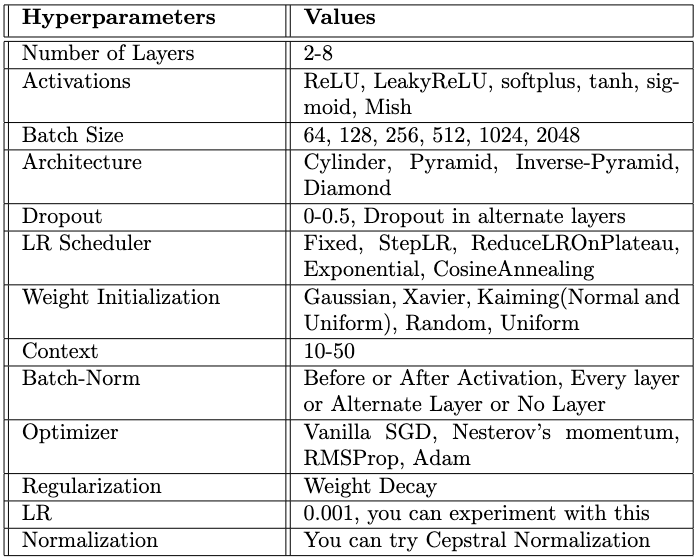# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.



---


**Resource:** https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/



---



**API Key:** {"username":"llynoirx","key":"b2ce5eadd838f8ca8066ecc979807b17"}


---



In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"llynoirx","key":"b2ce5eadd838f8ca8066ecc979807b17"}')

# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# # commands to download data from kaggle
# !kaggle competitions download -c 11785-hw1p2-s24

# !unzip -qo /content/11785-hw1p2-s24.zip -d '/content'

# Analyze & Define Dataset

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?



---


**Resources:**  
- https://www.geeksforgeeks.org/python-os-path-join-method/

-   https://numpy.org/doc/stable/reference/generated/numpy.pad.html

- https://www.w3schools.com/python/python_lists_comprehension.asp


---
**Notes:**
- add context to first and last frame via zero padding; if context=5 and have utterance of dimension (1000, 27), adding context => (1010, 27)
- input layer: (1+2\*context_size)\*27 nodes

### Analyzing Dataset


In [51]:
# Read in datasets

dev_transcript_path = "/content/11-785-s24-hw1p2/dev-clean/transcript/"
dev_mfcc_path = "/content/11-785-s24-hw1p2/dev-clean/mfcc"
train_mfcc_path = "/content/11-785-s24-hw1p2/train-clean-100/mfcc"
test_mfcc_path = "/content/11-785-s24-hw1p2/test-clean/mfcc"

dev_transcripts, dev_mfcc, train_mfcc, test_mfcc = [], [], [], []

for file in os.listdir(dev_transcript_path):
    transcript = np.load(os.path.join(dev_transcript_path, file))
    dev_transcripts.append(transcript)

for file in os.listdir(dev_mfcc_path):
    mfcc = np.load(os.path.join(dev_mfcc_path, file))
    dev_mfcc.append(mfcc)

for file in os.listdir(train_mfcc_path):
    mfcc = np.load(os.path.join(train_mfcc_path, file))
    train_mfcc.append(mfcc)

for file in os.listdir(test_mfcc_path):
    mfcc = np.load(os.path.join(test_mfcc_path, file))
    test_mfcc.append(mfcc)

print("Number of dev transcripts:", len(dev_transcripts)) #2703
print("Number of dev mfccs:", len(dev_mfcc)) #2703
print("Number of train mfccs:", len(train_mfcc)) #28539
print("Number of test mfccs:", len(test_mfcc)) #2620

Number of dev transcripts: 2703
Number of dev mfccs: 2703
Number of train mfccs: 28539
Number of test mfccs: 2620


In [ ]:
# Count phoneme occurences in dev transcript (for HW1 Quiz)

for phoneme in PHONEMES:
  count = 0
  for transcript in dev_transcripts:
      count += (transcript==phoneme).sum()
  print(phoneme, "has", count, "occurrences")


### Defining Dataset Class

In [ ]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes

        # TODO: MFCC directory - use partition to access train/dev directories from kaggle data using root
        self.mfcc_dir       = os.path.join(root, partition, "mfcc/")

        # TODO: Transcripts directory - use partition to access train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root, partition, "transcript/")

        # TODO: List files in sefl.mfcc_dir using os.listdir in sorted order
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))

        # TODO: List files in self.transcript_dir using os.listdir in sorted order
        transcript_names    = sorted(os.listdir(self.transcript_dir))

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []

        # TODO: Iterate through mfccs and transcripts
        for i in range(len(mfcc_names)):
        #   Load a single mfcc
            mfcc        = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc_mean = np.mean(mfcc)
            mfcc_sd =  np.std(mfcc)
            cepstral_norm = (mfcc - mfcc_mean)/(mfcc_sd + 1e-5)
        #   Load the corresponding transcript
            transcript  = np.load(os.path.join(self.transcript_dir,transcript_names[i]))
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript = transcript[1:-1]
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

        # NOTE:
        # Each mfcc is of shape T1 x 27, T2 x 27, ...
        # Each transcript is of shape (T1+2) x 27, (T2+2) x 27 before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 27 (Where T = T1 + T2 + ...)
        self.mfccs          = np.concatenate(self.mfccs)

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        self.transcripts    = np.concatenate(self.transcripts)
        # Hint: Use numpy to concatenate

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame
        # From hw0, you will be knowing what context is.
        # We can introduce context by padding zeros on top and bottom of self.mfcc
        self.mfccs = np.pad(self.mfccs, ((self.context, self.context), (0, 0)), mode='constant', constant_values=0) # TODO


        # The available phonemes in the transcript are of string data type
        # But the neural network cannot predict strings as such.
        # Hence, we map these phonemes to integers
        # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
        self.transcripts = [PHONEMES.index(t) for t in self.transcripts]

        # Now, if an element in self.transcript is 0, it means that it is 'SIL' (as per the above example)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind: ind+2*self.context+1]

        # After slicing, you get an array of shape 2*context+1 x 27. But our MLP needs 1d data and not 2d.
        frames = frames.flatten() # TODO: Flatten to get 1d data

        frames      = torch.FloatTensor(frames) # Convert to tensors
        phonemes    = torch.tensor(self.transcripts[ind])

        return frames, phonemes

In [ ]:
class AudioTestDataset(torch.utils.data.Dataset):
    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "test-clean"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes

        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir       = os.path.join(root, partition, "mfcc/")

        # TODO: List files in sefl.mfcc_dir using os.listdir in sorted order
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))

        self.mfccs =[]

        # TODO: Iterate through mfccs
        for i in range(len(mfcc_names)):
        #   Load a single mfcc
            mfcc        = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc_mean = np.mean(mfcc)
            mfcc_sd =  np.std(mfcc)
            cepstral_norm = (mfcc - mfcc_mean)/(mfcc_sd + 1e-5)
        #   Append each mfcc to self.mfcc
            self.mfccs.append(mfcc)

        # NOTE:
        # Each mfcc is of shape T1 x 27, T2 x 27, ...
        # Each transcript is of shape (T1+2) x 27, (T2+2) x 27 before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 27 (Where T = T1 + T2 + ...)
        self.mfccs          = np.concatenate(self.mfccs)
        # Hint: Use numpy to concatenate

        # Length of the dataset is now the length of concatenated mfccs
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame
        # From hw0, you will be knowing what context is.
        # We can introduce context by padding zeros on top and bottom of self.mfcc
        self.mfccs = np.pad(self.mfccs, ((self.context, self.context), (0, 0)), mode='constant', constant_values=0) # TODO

    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind: ind+2*self.context+1]

        # After slicing, you get an array of shape 2*context+1 x 27. But our MLP needs 1d data and not 2d.
        frames = frames.flatten() # TODO: Flatten to get 1d data

        frames      = torch.FloatTensor(frames) # Convert to tensors

        return frames


# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.


---


**Resources:**  
https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive


---


![](https://drive.google.com/uc?export=view&id=1Mr35iOdRwCe3C3tnuqwwl51bu-FPkGCy)

Also recommended:
- Regularized Dropout (R-Drop)
- Time & Frequency Masking


In [ ]:
config = {
    'epochs'        : 5,
    'batch_size'    : 1024,
    'context'       : 20,
    'init_lr'       : 1e-3,
    'architecture'  : 'very-low-cutoff'
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

# Create Datasets & Dataloaders

In [ ]:
#TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(
    root = "/content/11-785-s24-hw1p2/",
    context = config['context']
)

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(
    root = "/content/11-785-s24-hw1p2/",
    context = config['context'],
    partition = "dev-clean"
)

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(
    root = "/content/11-785-s24-hw1p2/",
    context = config['context']
)

In [ ]:
# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(
    root = "/content/11-785-s24-hw1p2/",
    context = config['context']
)

In [ ]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*27)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  1024
Context        :  20
Input size     :  1107
Output symbols :  42
Train dataset samples = 36091157, batches = 35246
Validation dataset samples = 1928204, batches = 1884
Test dataset samples = 36091157, batches = 35246


In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Test dataset samples = 1934138, batches = 1889


In [ ]:
# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)
    break

torch.Size([1024, 1107]) torch.Size([1024])


# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [ ]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
class Network(torch.nn.Module):

    def __init__(self, input_size, output_size):

        super(Network, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, output_size)
        )

    def forward(self, x):
        out = self.model(x)

        return out

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [ ]:
INPUT_SIZE  = (2*config['context'] + 1) * 27 # Why is this the case?
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device)
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 24 million parameters for HW1 (including ensembles)

                 Kernel Shape Output Shape    Params Mult-Adds
Layer                                                         
0_model.Linear_0  [1107, 512]  [1024, 512]  567.296k  566.784k
1_model.ReLU_1              -  [1024, 512]         -         -
2_model.Linear_2    [512, 42]   [1024, 42]   21.546k   21.504k
---------------------------------------------------------------
                        Totals
Total params          588.842k
Trainable params      588.842k
Non-trainable params       0.0
Mult-Adds             588.288k


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[1107, 512]","[1024, 512]",567296.0,566784.0
1_model.ReLU_1,-,"[1024, 512]",NaN,NaN
2_model.Linear_2,"[512, 42]","[1024, 42]",21546.0,21504.0


In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

optimizer = torch.optim.Adam(model.parameters(), lr= config['init_lr']) #Defining Optimizer
# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStepLR, CosineAnnealingLR, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [ ]:
torch.cuda.empty_cache()
gc.collect()

36

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        ### Move Data to Device (Ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        ### Forward Propagation
        logits  = model(frames)

        ### Loss Calculation
        loss    = criterion(logits, phonemes)

        ### Backward Propagation
        loss.backward()

        ### Gradient Descent
        optimizer.step()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)

    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [ ]:
wandb.login(key="f3b2c9738d42f0a8cccb942fd7050e6854a48f84") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: llynoirx (team-11785). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "first-run", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [ ]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20240127_032522-95w1a6xf/files/model_arch.txt']

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ### Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best

### Finish your wandb run
#run.finish()


Epoch 1/5


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 60.9600%	Train Loss 1.3078	 Learning Rate 0.0010000
	Val Acc 61.0813%	Val Loss 1.2991

Epoch 2/5


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 62.5976%	Train Loss 1.2473	 Learning Rate 0.0010000
	Val Acc 61.9456%	Val Loss 1.2708

Epoch 3/5


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 62.8757%	Train Loss 1.2384	 Learning Rate 0.0010000
	Val Acc 61.5495%	Val Loss 1.2841

Epoch 4/5


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 62.9825%	Train Loss 1.2348	 Learning Rate 0.0010000
	Val Acc 62.0852%	Val Loss 1.2749

Epoch 5/5


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 63.0629%	Train Loss 1.2327	 Learning Rate 0.0010000
	Val Acc 61.9634%	Val Loss 1.2770


# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [ ]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.inference_mode(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = [PHONEMES[i] for i in torch.argmax(logits, dim=1)]

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # TODO
            test_predictions.extend(predicted_phonemes)

    return test_predictions

In [ ]:
predictions = test(model, test_loader)

  0%|          | 0/1889 [00:00<?, ?it/s]

In [ ]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw1p2-s24 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 19.4M/19.4M [00:03<00:00, 6.02MB/s]
Successfully submitted to 11785-HW1P2-S24